!pip install -U pip

!pip install wikipedia-api

!pip install umap-learn

!pip install --upgrade wikipedia-api

In [7]:
import re
import umap
import time
import pandas as pd
import wikipediaapi
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

from config import *

In [8]:
not_working_pages = []

wiki_object = wikipediaapi.Wikipedia("wikiScraping (fake@gmail.com)", "en")

page_test = wiki_object.page("Python_(programming_language)")
page_text = wiki_object.extracts(page=page_test)

print(f"Page title: {page_test.title}")
print(f"Text : {page_text}")
print(len(page_text))

Page title: Python (programming language)
Text : Python is a high-level, general-purpose programming language. Its design philosophy emphasizes code readability with the use of significant indentation.
Python is dynamically type-checked and garbage-collected. It supports multiple programming paradigms, including structured (particularly procedural), object-oriented and functional programming. It is often described as a "batteries included" language due to its comprehensive standard library.
Guido van Rossum began working on Python in the late 1980s as a successor to the ABC programming language and first released it in 1991 as Python 0.9.0. Python 2.0 was released in 2000. Python 3.0, released in 2008, was a major revision not completely backward-compatible with earlier versions. Python 2.7.18, released in 2020, was the last release of Python 2.
Python consistently ranks as one of the most popular programming languages, and has gained widespread use in the machine learning community.
9

In [9]:
# Extract pages from other fields and save it as JSON file


def ExtractWikiPages(topics : list, wiki_object):
    """
    Fetches and returns the cleaned text content of a Wikipedia page for a given title.
    
    Parameters: 
        topics (dict) : List of topics
        wiki_objet : API instance
            
    returns:
        wiki_data : dict
        Dict of extracted topics, with topics as key and extracted page as value
    """
    wiki_data = {}
    
    for topic in topics:
        wiki_data[topic] = cleaning_text(wiki_object.extracts(wiki_object.page(topic)))

    return  wiki_data    

In [10]:
def cleaning_text(text: str):
    """
    Cleans extracted Wikipedia page text by removing punctuation, non-alpha characters,
    and multiple spaces while converting to lowercase.

    Arguments:
        text (str): Raw text extracted from the Wikipedia page.

    Returns:
        str: Cleaned text.
    """
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\n", "", text)  # Remove newline characters
    text = re.sub(r"\s+", " ", text)  # Replace multiple spaces with a single space
    text = re.sub(r"[.,;:\'\"“”’]", "", text)  # Remove punctuations
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove non-alpha characters
    return text

check clean-text library

In [11]:
def vectorize(data: pd.DataFrame):
    """
    Vectorizes the corpus using the TF-IDF method, creating a feature matrix where each row corresponds
    to a document, and each column corresponds to a word in the vocabulary.

    Arguments:
        data (pd.DataFrame): DataFrame of documents to vectorize.

    Returns:
        pd.DataFrame: TF-IDF weighted term-document matrix as a DataFrame.
        vectorizer (TfidfVectorizer): Fitted TF-IDF vectorizer object for future use.
    """
    # Initialize the TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(max_features=3000, stop_words="english")

    # Fit and transform the documents
    X = vectorizer.fit_transform(data["Text"])

    # Convert the sparse matrix into a dense DataFrame
    tfidf_df = pd.DataFrame(
        X.toarray(), columns=vectorizer.get_feature_names_out(), index=data.index
    )

    return tfidf_df, vectorizer

In [12]:
def vectorize_new_topic(new_topic_texts: list, vectorizer: object):
    """
    Vectorizes new topics using the already fitted TF-IDF vectorizer from the original corpus.

    Arguments:
        new_topic_texts (list): List of texts for new topics to be vectorized.
        vectorizer (TfidfVectorizer): The pre-fitted TF-IDF vectorizer.

    Returns:
        new_topic_vector (sparse matrix): TF-IDF matrix for the new topics.
        features (array): List of feature names (words) corresponding to the TF-IDF vectors.
    """
    new_topic_vectors = vectorizer.transform(new_topic_texts)

    return new_topic_vectors, vectorizer.get_feature_names_out()

In [20]:
def project_and_visualize_clusters(
    original_data: pd.DataFrame,
    new_topic_vectors,
    index: list,
    new_topic_labels: list,
    features: list,
    n_clusters=8,
):
    """
    Combines the original data and new topics, applies UMAP for dimensionality reduction,
    clusters the combined data using k-means, and visualizes the results using a scatter plot.

    Arguments:
        original_data (pd.DataFrame): The TF-IDF matrix of the original corpus.
        new_topic_vectors (sparse matrix): The TF-IDF vectorized data for new topics.
        index (list): List of labels or categories for the original data.
        new_topic_labels (list): Labels for the new topics.
        features (list): Feature names (words) corresponding to the combined data.
        n_clusters (int): Number of clusters for k-means clustering.
    """
    # Combine original data with the new topic
    new_topic_df = pd.DataFrame(
        new_topic_vectors.toarray(), columns=features, index=new_topic_labels
    )
    combined_data = pd.concat([original_data, new_topic_df])

    # Apply UMAP for dimensionality reduction on combined data
    umap_model = umap.UMAP(n_components=2, random_state=42)
    tfidf_2d_combined = umap_model.fit_transform(combined_data)

    # Run k-Means clustering on the combined UMAP-reduced data
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(tfidf_2d_combined)

    # Create a DataFrame for visualization
    umap_df_combined = pd.DataFrame(tfidf_2d_combined, columns=["UMAP1", "UMAP2"])
    umap_df_combined["category"] = index + new_topic_labels
    umap_df_combined["cluster"] = clusters

    # Plot UMAP with the new topic and updated clusters
    plt.figure(figsize=(10, 8))
    scatter_plot = sns.scatterplot(
        x="UMAP1",
        y="UMAP2",
        hue="cluster",
        palette=sns.color_palette("hsv", n_clusters),
        data=umap_df_combined,
        legend="full",
    )

    # Add annotations (True Class) to the points
    for i in range(umap_df_combined.shape[0]):
        plt.text(
            umap_df_combined["UMAP1"].iloc[i],  # x-coordinate
            umap_df_combined["UMAP2"].iloc[i],  # y-coordinate
            umap_df_combined["category"].iloc[i],  # True class or label
            fontsize=9,
            color="black",
            ha="right",
            va="bottom",
        )

    handles, labels = scatter_plot.get_legend_handles_labels()
    custom_labels = [f"Cluster {i}" for i in range(n_clusters)]
    plt.legend(handles=handles, labels=custom_labels, title="Clusters")

    plt.title("2D UMAP Projection with New Topic and Updated Clusters")

    formatted_time = time.strftime("%Y-%m-%d_%H-%M-%S")
    filename = f'{OUTPUT_DIR}/scraping_wikipedia_result_2d_{formatted_time}.png'
    
    plt.savefig(filename, format='png')
    
    plt.show()


In [14]:
categories = {
"AI": AI_PAGES,
"CS": COMPUTER_SCIENCE_PAGES,
"Law": LAW_PAGES,
"Literature": LITERATURE_PAGES,
"Philosophy": PHILOSOPHY_PAGES,
"History": HISTORY_PAGES,
"Sports": SPORTS_PAGES,
"Music": MUSIC_PAGES
}

In [15]:
documents = {}

for category, pages in categories.items():
    wiki_data = ExtractWikiPages(pages, wiki_object=wiki_object)
    wiki_data = {topic: text for topic, text in wiki_data.items() if text != ""}
    
    documents[category] = wiki_data.items()
    
documents

{'AI': dict_items([('Artificial_intelligence', 'artificial intelligence ai refers to the capability of computational systems to perform tasks typically associated with human intelligence such as learning reasoning problemsolving perception and decisionmaking it is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals such machines may be called aishighprofile applications of ai include advanced web search engines eg google search recommendation systems used by youtube amazon and netflix virtual assistants eg google assistant siri and alexa autonomous vehicles eg waymo generative and creative tools eg chatgpt and ai art and superhuman play and analysis in strategy games eg chess and go however many ai applications are not perceived as ai a lot of cutting edge ai has filtered into general applications 

In [16]:
data = []

for category, pages in documents.items():
    for title, text in pages:
        data.append({"Category": category, "Title": title, "Text": text})

data = pd.DataFrame(data).set_index("Category")
data

,Title,Text
Category,,
AI,Artificial_intelligence,artificial intelligence ai refers to the capab...
AI,Machine_learning,machine learning ml is a field of study in art...
AI,Deep_learning,deep learning is a subset of machine learning ...
AI,Neural_network,a neural network is a group of interconnected ...
AI,Natural_language_processing,natural language processing nlp is a subfield ...
...,...,...
Music,Choir,a choir kwire also known as a chorale or chor...
Music,Musical_instrument,a musical instrument is a device created or ad...
Music,Composer,a composer is a person who writes music the te...


In [17]:
# Vectorize the documents using TF-IDF
tf_idf, vectorizer = vectorize(data)
tf_idf

,abbey,abbreviated,ability,able,abolition,absence,absolute,abstract,abstraction,academia,...,yangtze,year,years,york,young,younger,youth,yuan,zealand,zero
Category,,,,,,,,,,,,,,,,,,,,,
AI,0.0,0.0,0.074030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AI,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AI,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AI,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AI,0.0,0.0,0.134499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Music,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Music,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.086986,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Music,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
test_topic_pages = [
    "Electric_car",
    "Internet",
    "Feminism",
    "Cyberbullying",
    "Global_warming",
    "Vikings",
    "Napoleon",
    "COVID-19",
    "Harry_Potter",
    "Social_media",
]

test_topic_labels = [f"{title}" for title in test_topic_pages]

In [19]:
# Get texts and index for new topics.
test_topic_texts = ExtractWikiPages(test_topic_pages, wiki_object=wiki_object).values()
test_topic_texts

dict_values(['an electric car or electric vehicle ev is a passenger automobile that is propelled by an electric traction motor using electrical energy as the primary source of propulsion the term normally refers to a plugin electric vehicle typically a battery electric vehicle bev which only uses energy stored in onboard battery packs but broadly may also include plugin hybrid electric vehicle phev rangeextended electric vehicle reev and fuel cell electric vehicle fcev which can convert electric power from other fuels via a generator or a fuel cellcompared to conventional internal combustion engine ice vehicles electric cars are quieter more responsive have superior energy conversion efficiency and no exhaust emissions as well as a lower overall carbon footprint from manufacturing to end of life even when a power plant supplying the electricity might add to its emissions due to the superior efficiency of electric motors electric cars also generate less waste heat thus reducing the need

In [21]:
# Vectorize the new corpus
new_topic_vectors, features = vectorize_new_topic(test_topic_texts, vectorizer)

C:\Users\flori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\flori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\flori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\jo

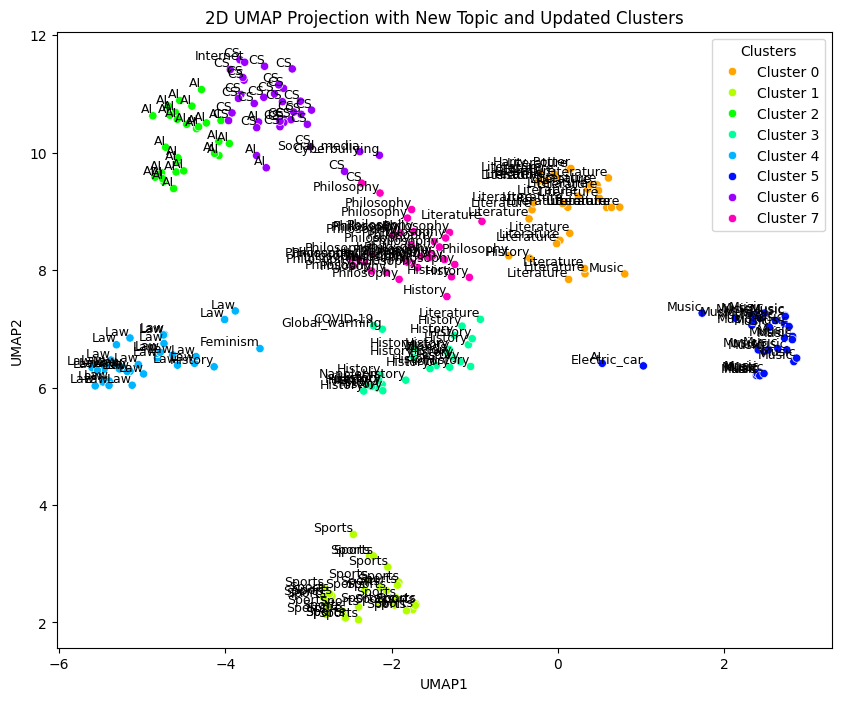

In [22]:
# Project and visualize clusters
project_and_visualize_clusters(
    tf_idf,
    new_topic_vectors,
    index=data.index.tolist(),
    new_topic_labels=test_topic_labels,
    features=features,
)